In [37]:
import json
import math
import os
import requests
import scipy
import tifffile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from datetime import datetime as dt
from scipy import stats as st
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.layers import concatenate
from keras import metrics
from keras.models import Sequential
from keras.layers import Activation, Dense

from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Read Tiles Dataset**

In [38]:
tiles = pd.read_csv(r'/content/drive/MyDrive/capstone/Tiles_expanded_balanced.csv')

In [39]:
tiles.head(5)

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving,Collisions_Future,Collisions_Historical,Collision_binary_historical,Collision_binary_future
0,1373,1373,37.719094,37.719998,-122.389033,-122.390173,37.719546,-122.389603,8.0,2.0,2.0,1.0,1.0,1,1
1,2411,2411,37.726323,37.727227,-122.401575,-122.402715,37.726775,-122.402145,1.0,0.0,0.0,0.0,1.0,1,0
2,9047,9047,37.776925,37.777829,-122.409555,-122.410695,37.777377,-122.410125,0.0,0.0,0.0,1.0,1.0,1,1
3,8903,8903,37.775118,37.776021,-122.499624,-122.500765,37.775570,-122.500195,4.0,2.0,0.0,0.0,1.0,1,0
4,10938,10938,37.793190,37.794094,-122.435778,-122.436918,37.793642,-122.436348,4.0,1.0,0.0,0.0,1.0,1,0


In [40]:
tiles.columns

Index(['Unnamed: 0', 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat',
       'Mid_long', 'Stop_Signs', 'Bus_stop', 'Paving', 'Collisions_Future',
       'Collisions_Historical', 'Collision_binary_historical',
       'Collision_binary_future'],
      dtype='object')

In [41]:
#tiles column names
columns = ['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Bus_stop', 'Paving', 'Future', 'Historical',
       'Collision_binary_historical', 'Collision_binary_future']

# x: 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat', 'Mid_long',
#    'Stop_Signs', 'Bus_stop', 'Paving', 'Future', 'Historical',
#    'Collision_binary_historical'
# y: 'Collision_binary_future'

X = tiles[['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Bus_stop', 'Paving', 'Collisions_Future', 'Collisions_Historical',
       'Collision_binary_historical']]
y = tiles[['Collision_binary_future']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

In [42]:
#tiles.rename(columns={'Collision_binary_future': 'label'})

**RANDOM FOREST**

https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [43]:
from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(20, input_dim=13, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=1)

Epoch 1/20
50/50 [==============================] - 1s 3ms/step - loss: 125.2054 - accuracy: 0.5335
Epoch 2/20
50/50 [==============================] - 0s 3ms/step - loss: 5.8099 - accuracy: 0.5860
Epoch 3/20
50/50 [==============================] - 0s 3ms/step - loss: 4.8516 - accuracy: 0.5985
Epoch 4/20
50/50 [==============================] - 0s 3ms/step - loss: 2.1726 - accuracy: 0.5969
Epoch 5/20
50/50 [==============================] - 0s 3ms/step - loss: 1.7973 - accuracy: 0.6595
Epoch 6/20
50/50 [==============================] - 0s 4ms/step - loss: 4.2188 - accuracy: 0.5953
Epoch 7/20
50/50 [==============================] - 0s 3ms/step - loss: 3.9348 - accuracy: 0.5985
Epoch 8/20
50/50 [==============================] - 0s 3ms/step - loss: 1.0798 - accuracy: 0.6873
Epoch 9/20
50/50 [==============================] - 0s 3ms/step - loss: 1.7982 - accuracy: 0.6621
Epoch 10/20
50/50 [==============================] - 0s 3ms/step - loss: 3.8361 - accuracy: 0.6111
Epoch 11/20
50/50

In [44]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

309/309 [==============================] - 0s 1ms/step


In [45]:
#from sklearn.metrics import auc
#auc_keras = auc(fpr_keras, tpr_keras)

In [46]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

<ipython-input-46-c475c0c56d17>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


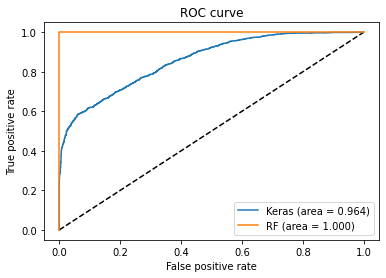

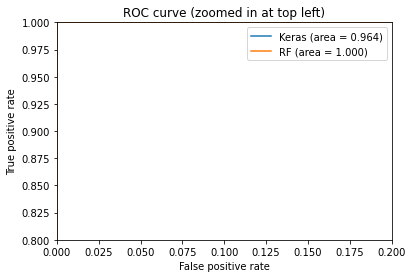

In [47]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

**LOGISTIC REGRESSION**

In [48]:
from sklearn.linear_model import LogisticRegression
# Supervised transformation based on random forests

logr = LogisticRegression(random_state=0, max_iter=1000)
#rf = RandomForestClassifier(max_depth=3, n_estimators=10)
logr.fit(X_train, y_train)

y_pred_logr = logr.predict_proba(X_test)[:, 1]
fpr_logr, tpr_logr, thresholds_logr = roc_curve(y_test, y_pred_logr)
auc_logr = auc(fpr_logr, tpr_logr)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


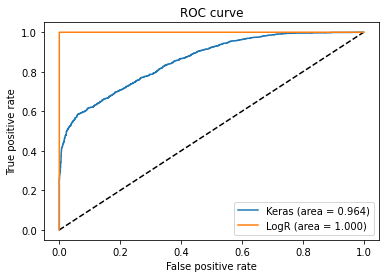

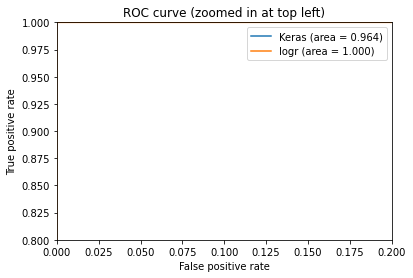

In [49]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_logr, tpr_logr, label='LogR (area = {:.3f})'.format(auc_logr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_logr, tpr_logr, label='logr (area = {:.3f})'.format(auc_logr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

**LINEAR REGRESSION**

In [51]:
def create_linear_model():

    input = tf.keras.layers.Input(shape=(13,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

   # normalized = layers.Normalization(input_shape=[5,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1)(input)
    
    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    new_model = Sequential()
    new_model.add(linear_model)
    new_model.add(Dense(1,activation='sigmoid'))

    new_model.summary()

    new_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error' ,
        metrics = [tf.keras.metrics.Accuracy()]
        )
    
    return new_model

linear_model = create_linear_model()

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = create_linear_model()
keras_model.fit(df_train[['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Bus_stop', 'Paving', 'Future', 'Historical',
       'Collision_binary_historical']], df_train[['Collision_binary_future']], epochs=20, batch_size=100, verbose=1)

#history = linear_model.fit(
#    np.asarray(df_train[['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid_lat', 'Mid_long',
#       'Stop_Signs', 'Bus_stop', 'Paving', 'Future', 'Historical',
#       'Collision_binary_historical']]).astype('float32'),
#    df_train[['Collision_binary_future']],
#    epochs=20,
    # Suppress logging.
#     verbose=1,
    # Calculate validation results on 20% of the training data.
#    validation_split = 0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear_model (Functional)   (None, 1)                 14        
                                                                 
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear_model (Functional)   (None, 1)                 14        
                                                                 
 dense_13 (Dense)            (None, 1)                 2         
                                                                 
Total params: 16
Trainable params: 1

NameError: ignored

In [52]:
def plot_loss(history):
    #mp.plot(history.history['loss'], label='loss')
    #mp.plot(history.history['val_loss'], label='val_loss')
    mp.plot(history.history['accuracy'], label='accuracy')
    mp.plot(history.history['val_accuracy'], label='val_accuracy')
    mp.ylim([min(history.history['accuracy']), max(history.history['accuracy'])])
    mp.xlabel('Epoch')
    mp.ylabel('Loss')
    mp.legend()
    mp.grid(True)

In [53]:
plot_loss(history)

NameError: ignored

**Linear Classifier**

Source: https://www.guru99.com/linear-classifier-tensorflow.html

In [ ]:
df_train, df_test = train_test_split(tiles[columns], test_size=0.2)

In [ ]:
continuous_features = [tf.feature_column.numeric_column(k) for k in columns]

In [ ]:
#Source: https://www.guru99.com/linear-classifier-tensorflow.html
model = tf.estimator.LinearClassifier(
    n_classes = 2,
    model_dir="ongoing/train", 
    feature_columns=continuous_features)

In [ ]:
FEATURES = columns
LABEL= 'Collision_binary_future'
def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
       x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),
       y = pd.Series(data_set[LABEL].values),
       batch_size=n_batch,   
       num_epochs=num_epochs,
       shuffle=shuffle)

In [ ]:
model.train(input_fn=get_input_fn(df_train, 
                                      num_epochs=None,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)

In [ ]:
model.evaluate(input_fn=get_input_fn(df_test, 
                                      num_epochs=1,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)

**LOGISTIC REGRESSION**

In [ ]:
#from sklearn.preprocessing import LabelEncoder
# split into input (X) and output (Y) variables
x = tiles[columns].iloc[:,12].astype(float)
y = tiles[columns].iloc[:,13].astype(float)
# encode class values as integers
#encoder = LabelEncoder()
#encoder.fit(y)
#encoded_Y = encoder.transform(y)
#y = encoded_Y

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
#                                 test_size=0.2, shuffle=True, random_state=104)

In [ ]:
#x_train.head()
#x_train.info()

In [ ]:
#x_test.head()
#x_test.info()

In [ ]:
#y_train#.head()

In [ ]:
#y_test#.head()

In [ ]:
def build_model(learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # Build a model using keras.Sequential.
  model = keras.Sequential()

  # Keras layers can do pre-processing. This layer will take our 28x28 images
  # and flatten them into vectors of size 784.
  model.add(keras.layers.Flatten())
  
  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a sigmoid to the result. The result is
  # binary logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
  ))

  # Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # We specify the binary_crossentropy loss (equivalent to log loss).
  # Notice that we are including 'binary accuracy' as one of the metrics that we
  # ask Tensorflow to report when evaluating the model.
  model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=[metrics.binary_accuracy])

  return model

In [ ]:
model = build_model(learning_rate=0.01)

# Fit the model.
history = model.fit(
  x = x_train,   # our binary training examples
  y = y_train,   # corresponding binary labels
  epochs=20,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.2, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history_df = pd.DataFrame(history.history)
display(history_df)

In [ ]:
def plot_loss(history):
    mp.plot(history.history['loss'], label='loss')
    mp.plot(history.history['val_loss'], label='val_loss')
    #mp.plot(history.history['binary_accuracy'], label='binary_accuracy')
    #mp.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
    mp.ylim([min(history.history['loss']), max(history.history['loss'])])
    mp.xlabel('Epoch')
    mp.ylabel('Loss')
    mp.legend()
    mp.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
def plot_loss(history):
    #mp.plot(history.history['loss'], label='loss')
    #mp.plot(history.history['val_loss'], label='val_loss')
    mp.plot(history.history['binary_accuracy'], label='binary_accuracy')
    mp.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
    mp.ylim([min(history.history['binary_accuracy']), max(history.history['binary_accuracy'])])
    mp.xlabel('Epoch')
    mp.ylabel('Accuracy')
    mp.legend()
    mp.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_predictions = model.predict(x_test).flatten()
print(test_predictions.shape)
print(test_predictions)

In [ ]:
test_predictions[test_predictions < 0.5] = 0
test_predictions[test_predictions >= 0.5] = 1
print("Accuracy = ", np.average(y_test == test_predictions))